# NLP - Sarcasm Detection
MLP Model + **Embedding** Layer

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow import keras
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1- Load Data

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/learning-datasets/sarcasm.json

--2023-10-29 12:56:24--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.27, 172.217.0.91, 2607:f8b0:4025:815::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2023-10-29 12:56:24 (83.2 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [ ]:
df = pd.read_json('sarcasm.json')

In [ ]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df.shape

(26709, 3)

In [ ]:
sentences = df['headline'].to_list()
labels = df['is_sarcastic'].to_list()

## 2- Pre-processing

In [ ]:
sw = stopwords.words('english')

In [ ]:
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
for s in sentences[:2]:
  print(s)

former versace store clerk sues over secret 'black code' for minority shoppers
the 'roseanne' revival catches up to our thorny political mood, for better and worse


In [ ]:
for i in range(len(sentences)):
  words = sentences[i].split()
  words_new = [w for w in words if w not in sw]
  sentences[i] = ' '.join(words_new)

In [ ]:
for s in sentences[:2]:
  print(s)

former versace store clerk sues secret 'black code' minority shoppers
'roseanne' revival catches thorny political mood, better worse


In [ ]:
training_size = 23000

train_sentences = sentences[:training_size]
validation_sentences = sentences[training_size:]

train_labels = labels[:training_size]
validation_labels = labels[training_size:]

train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

In [ ]:
vocab_size = 5000
embedding_dim = 16

In [ ]:
text_vectorization = TextVectorization(max_tokens=vocab_size, output_sequence_length=25)
text_vectorization.adapt(train_sentences)
print(len(text_vectorization.get_vocabulary()))

5000


In [ ]:
train_sequences = text_vectorization(train_sentences)
validation_sequences = text_vectorization(validation_sentences)
print(type(train_sequences))
print(train_sequences.shape)
print(validation_sequences.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(23000, 25)
(3709, 25)


## 3- Model Design

In [ ]:
model1 = Sequential([
    layers.Embedding(vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(25, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          80000     
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 25)                425       
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 80451 (314.26 KB)
Trainable params: 80451 (314.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 4- Training

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
history1 = model1.fit(train_sequences, train_labels,
                      batch_size=128,
                      epochs=50,
                      validation_data=(validation_sequences, validation_labels))

Epoch 1/50
180/180 [==============================] - 3s 7ms/step - loss: 0.6910 - accuracy: 0.5482 - val_loss: 0.6881 - val_accuracy: 0.5700
Epoch 2/50
180/180 [==============================] - 1s 4ms/step - loss: 0.6867 - accuracy: 0.5597 - val_loss: 0.6838 - val_accuracy: 0.5700
Epoch 3/50
180/180 [==============================] - 1s 4ms/step - loss: 0.6830 - accuracy: 0.5598 - val_loss: 0.6801 - val_accuracy: 0.5700
Epoch 4/50
180/180 [==============================] - 1s 4ms/step - loss: 0.6790 - accuracy: 0.5598 - val_loss: 0.6757 - val_accuracy: 0.5697
Epoch 5/50
180/180 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.5608 - val_loss: 0.6698 - val_accuracy: 0.5729
Epoch 6/50
180/180 [==============================] - 1s 3ms/step - loss: 0.6660 - accuracy: 0.5705 - val_loss: 0.6629 - val_accuracy: 0.6012
Epoch 7/50
180/180 [==============================] - 1s 3ms/step - loss: 0.6571 - accuracy: 0.6028 - val_loss: 0.6547 - val_accuracy: 0.6347
Epoch 

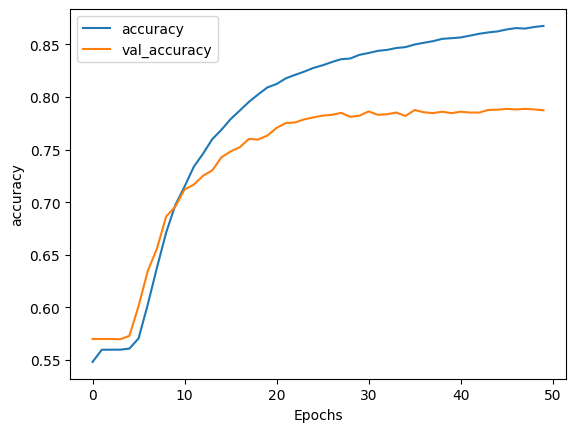

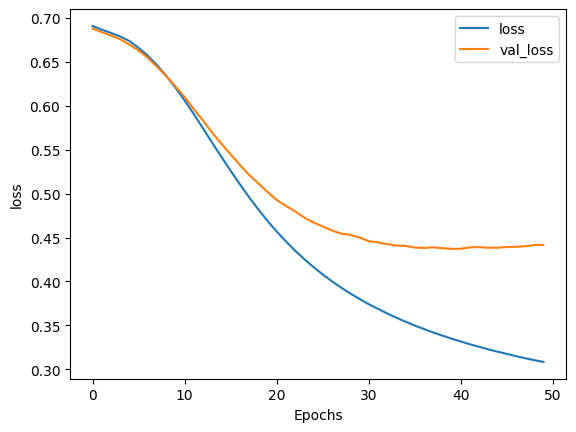

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

In [ ]:
test_sentences = ["granny starting to fear spiders in the garden might be real",
                  "game of thrones season finale showing this sunday night",
                  "TensorFlow book will be a best seller"]
# Remove stop-words
test_sequences = text_vectorization(test_sentences)
print(test_sequences)


tf.Tensor(
[[   1  765 2371  722    1 2153   57 2486  289 4009  102    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 119 2657 1124  147 2496 3105 1086 1446  156    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1  221    1 4009  942   39    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(3, 25), dtype=int64)


In [ ]:
preds = model1.predict(test_sequences)
print(preds)

1/1 [==============================] - 0s 92ms/step
[[0.08043804]
 [0.1521633 ]
 [0.03328642]]
